## Pytorch의 Autoencoder 이론 및 구현
[유투브 링크](https://youtu.be/zp8clK9yCro)

# Neural Network

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:
transform = transforms.ToTensor() # tensor 변환기 , 다른 변환기도 사용 가능

# 여러개의 변환기를 담을 수 있음
#transform = transforms.Compose([
#    transforms.ToTensor(),
#    transforms.Normalize((0.5),(0.5)) # 이미지 픽셀 값들을 평균 0.5, 표준편차 0.5로 정규화
#])
# 이미지는 pytorch tensor 로 변환한다
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data, batch_size=64, shuffle=True)

In [ ]:
# 항상 분석하기 전에 데이터가 어떤 범위에 있는지 알아야 한다
# iterator 객체를 통해 첫 번째 배치를 얻기
dataiter = iter(data_loader) 
images, labels = dataiter.next()
print(torch.min(images),torch.max(images)) # images의 값이 0과 1사이이다. 변환기를 다르게 사용하면 달라짐

tensor(0.) tensor(1.)


In [ ]:
# 그냥 Neural Network
class Autoencoder_Linear(nn.Module):
  def __init__(self):
    # (N, 784) -> 입력값
    # nn.Sequential 은 모듈을 담는 container
    super().__init__()
    self.encoder=nn.Sequential( 
        nn.Linear(28*28, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 12),
        nn.ReLU(),
        nn.Linear(12, 3) # (N,3)이 output ,마지막 계층은 활성화함수 필요없음 
    )

    self.decoder=nn.Sequential(
        nn.Linear(3,12),
        nn.ReLU(),
        nn.Linear(12,64),
        nn.ReLU(),
        nn.Linear(64,128),
        nn.ReLU(),
        nn.Linear(128,784), # 마지막 계층에서 다른 활성화 함수 사용함, 0과 1사이에 값을 출력하는 다른 함수 필요 -> sigmoid
        nn.Sigmoid()
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

# Note : input image의 값이 [-1,1] 이라면 output도 [-1,1] 이어야 하므로 nn.Tanh 함수 필요 


In [ ]:
model = Autoencoder_Linear()
criterion = nn.MSELoss() # Mean Squared Error 가 Loss function이 되도록 함 
# lr 과 weight_decay 를 적절히 변형해가며 최적을 찾아볼 수 있다
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5) # parameter를 갱신하는 것을 optimizer라고 함

In [ ]:
# Training 과정
num_epochs = 10  # 정확하게 하려면 숫자 늘리면 됨
outputs = []
for epoch in range(num_epochs):
  for (img, _) in data_loader:
    img = img.reshape(-1,28*28)
    recon = model(img) # 재구성된 이미지
    loss = criterion(recon,img)  

    optimizer.zero_grad() #gradient 0으로 초기화
    loss.backward() #backwarkd 하면서 gradient 구하는 과정
    optimizer.step() #매개변수 갱신 과정
  
  print(f'Epoch :{epoch+1}, Loss:{loss.item():.4f}')
  outputs.append((epoch,img,recon))

Epoch :1, Loss:0.0575
Epoch :2, Loss:0.0417
Epoch :3, Loss:0.0331
Epoch :4, Loss:0.0399
Epoch :5, Loss:0.0385
Epoch :6, Loss:0.0407
Epoch :7, Loss:0.0331
Epoch :8, Loss:0.0370
Epoch :9, Loss:0.0321
Epoch :10, Loss:0.0367


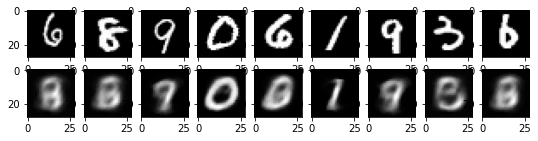

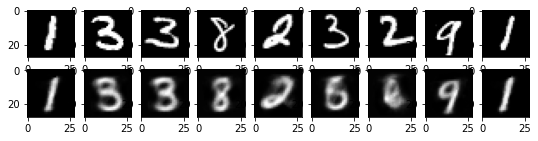

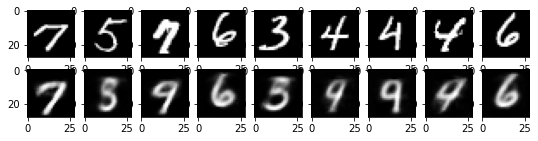

In [ ]:
# 실제 재구성된 이미지가 어떠한지 확인
for k in range(0, num_epochs, 4):
  plt.figure(figsize=(9,2))
  plt.gray()
  imgs = outputs[k][1].detach().numpy()
  recon = outputs[k][2].detach().numpy()

  # 입력값 출력
  for i, item in enumerate(imgs):
    if i>=9 : break
    plt.subplot(2, 9, i+1)
    item = item.reshape(-1, 28, 28) # 원래 image 크기로 변환
    # item: 1, 28, 28
    plt.imshow(item[0])

  for i, item in enumerate(recon):
    if i >= 9: break
    plt.subplot(2,9,9+i+1) # row_length + i + 1
    item = item.reshape(-1,28,28)
    # item: 1, 28, 28
    plt.imshow(item[0]) # 3차원이라 item[0] 이렇게 읽어야 하는듯

# Convolutional Neural network


In [ ]:
#Convolutional 과정을 좀더 이해해야 함
class Convolutional_Autoencoder(nn.Module):
  def __init__(self):
    # (N, 1, 28, 28) -> 입력값
    # nn.Sequential 은 모듈을 담는 container
    super().__init__()
    self.encoder=nn.Sequential( 
        nn.Conv2d(1, 16, 3, stride=2, padding=1), # (N, 16, 14, 14 )16은 output channel, 3은 kernel 수
        nn.ReLU(),
        nn.Conv2d(16, 32, 3, stride=2, padding=1), # N, 32, 7, 7
        nn.ReLU(),
        nn.Conv2d(32, 64, 7) # N, 64, 1, 1 -> Less Paramters
    )

    # N, 64, 1, 1
    self.decoder=nn.Sequential(
        nn.ConvTranspose2d(64, 32, 7), # N ,32 ,7 ,7
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14
        nn.ReLU(),
        nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28
        nn.Sigmoid()
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

# Note : input image의 값이 [-1,1] 이라면 output도 [-1,1] 이어야 하므로 nn.Tanh 함수 필요 
# nn.MaxPool2d -> nn.MaxUnpool2d , 실제 사용할 필요 없음

In [ ]:
model = Convolutional_Autoencoder()
criterion = nn.MSELoss() # Mean Squared Error 가 Loss function이 되도록 함 
# lr 과 weight_decay 를 적절히 변형해가며 최적을 찾아볼 수 있다
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5) # parameter를 갱신하는 것을 optimizer라고 함

In [ ]:
# Training 과정
num_epochs = 10  # 정확하게 하려면 숫자 늘리면 됨
outputs = []
for epoch in range(num_epochs):
  for (img, _) in data_loader:
    recon = model(img) # 재구성된 이미지
    loss = criterion(recon,img)

    optimizer.zero_grad() #gradient 0으로 초기화
    loss.backward() #backwarkd 하면서 gradient 구하는 과정
    optimizer.step() #매개변수 갱신 과정
  
  print(f'Epoch :{epoch+1}, Loss:{loss.item():.4f}')
  outputs.append((epoch,img,recon))

Epoch :1, Loss:0.0065
Epoch :2, Loss:0.0056
Epoch :3, Loss:0.0041
Epoch :4, Loss:0.0029
Epoch :5, Loss:0.0034
Epoch :6, Loss:0.0026
Epoch :7, Loss:0.0027
Epoch :8, Loss:0.0027
Epoch :9, Loss:0.0028
Epoch :10, Loss:0.0025


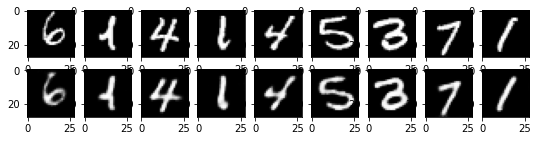

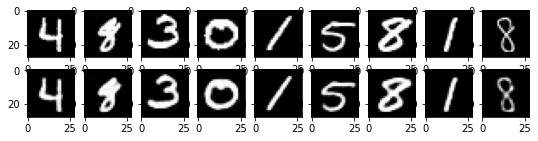

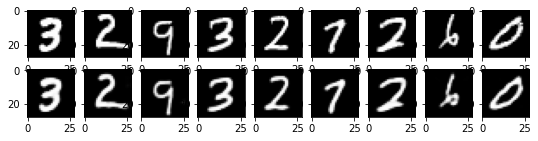

In [ ]:
# 실제 재구성된 이미지가 어떠한지 확인
for k in range(0, num_epochs, 4):
  plt.figure(figsize=(9,2))
  plt.gray()
  imgs = outputs[k][1].detach().numpy()
  recon = outputs[k][2].detach().numpy()

  # 입력값 출력
  for i, item in enumerate(imgs):
    if i>=9 : break
    plt.subplot(2, 9, i+1)
    # item: 1, 28, 28
    plt.imshow(item[0])

  for i, item in enumerate(recon):
    if i >= 9: break
    plt.subplot(2,9,9+i+1) # row_length + i + 1
    # item: 1, 28, 28
    plt.imshow(item[0]) # 3차원이라 item[0] 이렇게 읽어야 하는듯

In [ ]:
# MaxPool2d , inspect the encoded 좀 더 공부해 둘 것

In [ ]:
# What Happened